In [1]:
import pandas as pd
import numpy as np
import torch
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Setup

In [2]:
df_train = pd.read_csv("../../data/instruction-induction-data/datamodels/proportion_study/210_5/train_set.csv")
df_test = pd.read_csv("../../data/instruction-induction-data/datamodels/proportion_study/210_5/test_set.csv")
weights = torch.load("../../data/instruction-induction-data/datamodels/proportion_study/210_5/estimations/weights.pt")
bias = torch.load("../../data/instruction-induction-data/datamodels/proportion_study/210_5/estimations/bias.pt")


/tmp/ipykernel_3134252/2987387399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("../../data/instruction-induction-data/datamodels/proportion_study

In [3]:
weights = weights.cpu().detach().numpy()
bias = bias.cpu().detach().numpy()

In [4]:
weights.shape

(105, 420)

In [5]:
bias.shape

(105,)

In [6]:
df_test["weights"] = list(weights)   
df_test["bias"] = list(bias)


## A1: Show tasks by sample for top weights

In [7]:
from analysis_toolkit import *

In [8]:
df_test["estimation_task"] = df_test["weights"].apply(lambda indices: [df_train.loc[i, "task"] for i in range(len(indices))])


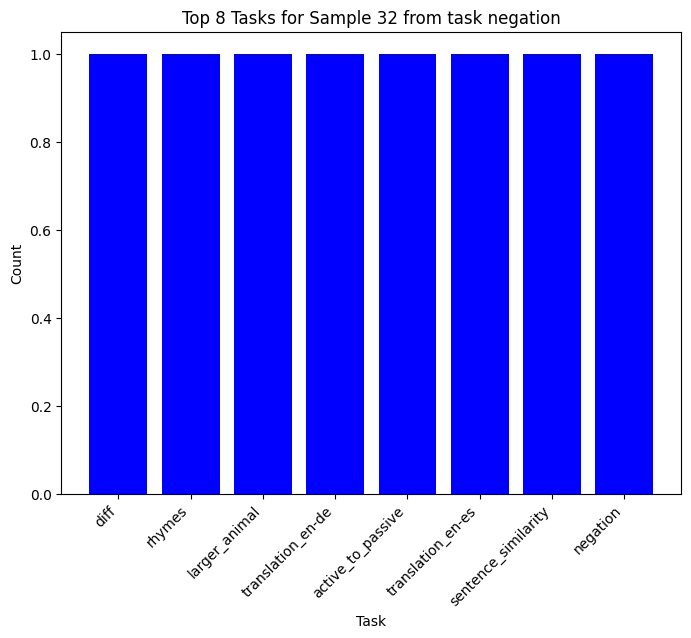

array([ 56, 195,  95, 347,  12, 367, 239, 133])

In [28]:
sample = 32
top_k = 8
show_tasks_by_sample(df_test, sample, top_k)

In [30]:
compare_i_most_high_samples(df_test, df_train, sample, 1)

Sample 32 input: In Wales, the language Welsh is used to educate.
Sample 32 output: In Wales, the language Welsh is not used to educate.
1 Most influential input: 51 1
1 Most influential output: 50


In [31]:
compare_i_most_high_samples(df_test, df_train, sample, 2)

Sample 32 input: In Wales, the language Welsh is used to educate.
Sample 32 output: In Wales, the language Welsh is not used to educate.
2 Most influential input: old
2 Most influential output: gold


In [24]:
compare_i_most_high_samples(df_test, df_train, sample, 3)

Sample 97 input: sleeve
Sample 97 output: chemise
3 Most influential input: pneumonia
3 Most influential output: n


In [25]:
compare_i_most_high_samples(df_test, df_train, sample, 400)

Sample 97 input: sleeve
Sample 97 output: chemise
400 Most influential input: 9312
400 Most influential output: nine thousand, three hundred and twelve


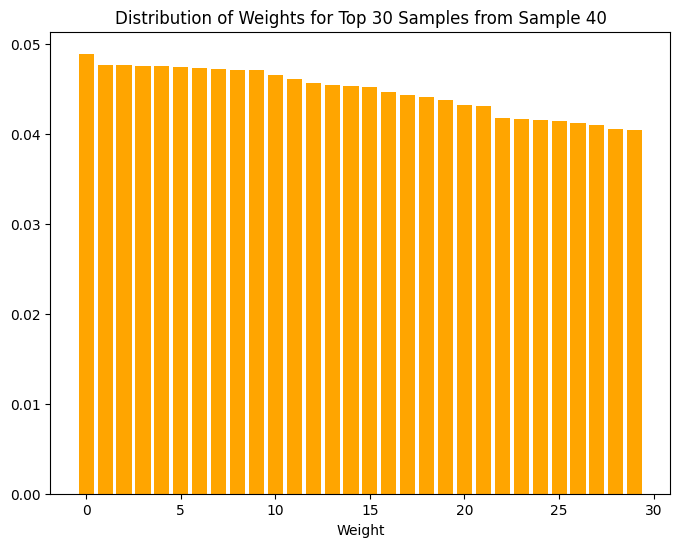

In [12]:
plot_hist_weights(df_test, 30, sample)

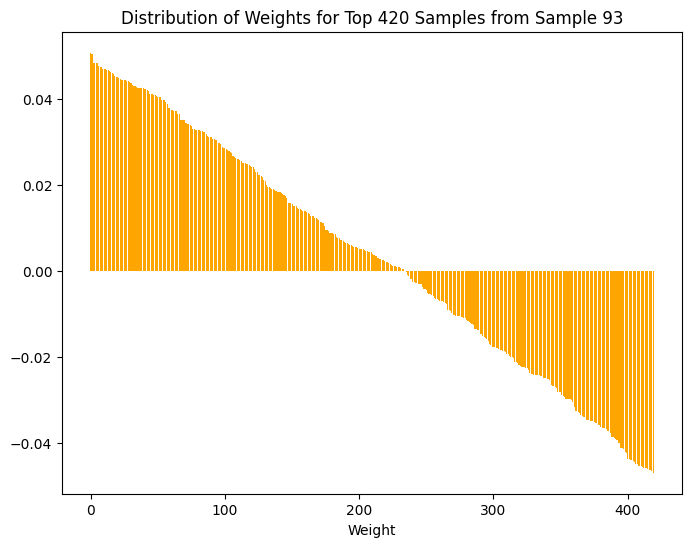

In [47]:
plot_hist_weights(df_test, 420, sample)

## A2: Analysis by Category

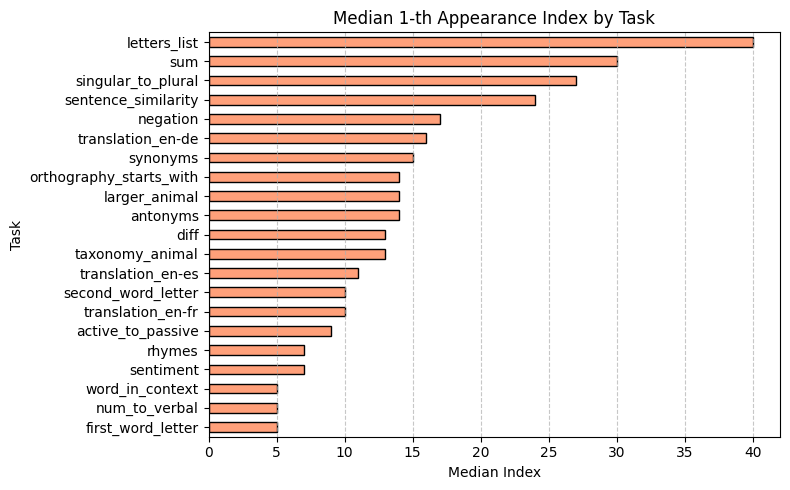

In [51]:
median_category_i_appeareance(df_test, 1)

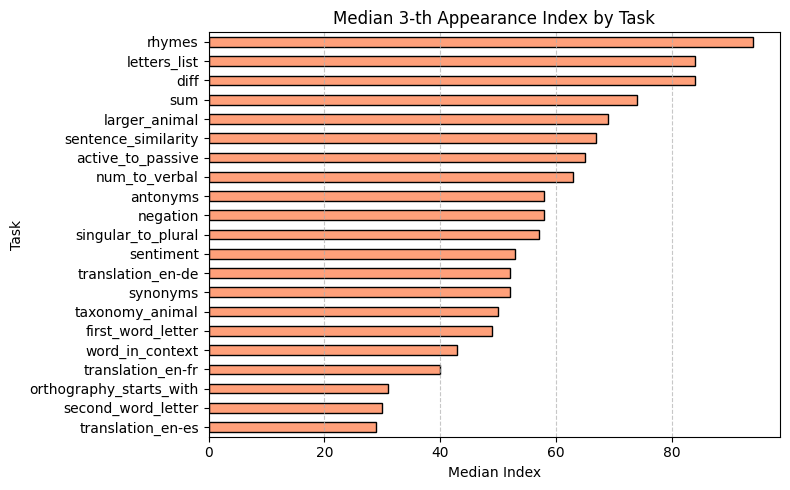

In [52]:
median_category_i_appeareance(df_test, 3)

## A3: Linear Models Evaluation

In [14]:
from src.datamodels.evaluator import LinearRegressorEvaluator
from pathlib import Path
import torch
import pandas as pd
import os


torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


weights = torch.load("../../data/instruction-induction-data/datamodels/proportion_study/210_5/estimations/weights.pt").to(device="cuda:0")
bias = torch.load("../../data/instruction-induction-data/datamodels/proportion_study/210_5/estimations/bias.pt").to(device="cuda:0")



# Directory containing your files
directory = Path("../../data/instruction-induction-data/datamodels/proportion_study/210_5/collections")

# List all files starting with "test_"
files = list(directory.glob("test_*"))

# Combine all files into a single DataFrame
df_list = [pd.read_feather(file) for file in files]
combined_df = pd.concat(df_list, ignore_index=True)

if torch.cuda.is_available():
    torch.set_default_device("cuda:0")


test_set_eval = torch.tensor(combined_df[["evaluation"]].values, dtype=torch.float32).to(device="cuda:0")
test_set_input = torch.tensor(combined_df[["input"]].values.tolist(), dtype=torch.float32).squeeze(1).to(device="cuda:0")

/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3134252/1759112491.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

In [15]:
evaluator = LinearRegressorEvaluator(
    weights_arr=weights,
    bias_arr=bias,
    targets=test_set_eval,
    inputs=test_set_input,
    metric="mse",
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)

In [16]:
evaluator.evaluate(8, 105)

0.09786935895681381

In [17]:
mse_per_model = evaluator.batch_evaluate([i for i in range(105)], 105)

In [27]:
import numpy as np
arr = mse_per_model.cpu().numpy()
np.where(arr >= 0.25)

(array([ 1,  2,  3,  4, 32]),)